**CS-GY 9223: Deep Learning Final Project: Solving Natural Language Processing with Disaster Tweets on Kaggle with BERT**

by:

Yan Sun    <ys3928@nyu.edu>

Zhenming Wang <zw2365@nyu.edu>

**Section 2: Fine-tune BERT**

Reference:https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

# Step 0: Set Up Working Environment And Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Deep Learning Final Project"   
                                       
%cd /content/gdrive/My Drive/Deep Learning Final Project

!pwd

/content/gdrive/My Drive/Deep Learning Final Project
/content/gdrive/My Drive/Deep Learning Final Project


In [3]:
!pip install -qq transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Detect GPU
if torch.cuda.is_available():   
   device = torch.device("cuda")
   print('Using GPU ', torch.cuda.get_device_name(0))
else:
   device = torch.device("cpu")
   print('Using CPU')

     |████████████████████████████████| 1.4MB 7.4MB/s 
     |████████████████████████████████| 2.9MB 24.2MB/s 
     |████████████████████████████████| 890kB 61.2MB/s 
Using GPU  Tesla P100-PCIE-16GB


# Step 1: BERT Preprocessing

## 1.1 Read input data into dataframse

In [4]:
# Read in the data cleaned data files 
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')


In [5]:
train.head()

,Unnamed: 0,id,keyword,location,text,target
0,0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


## 1.2 Helper function for tokenization and dataloader

In [29]:
# Helper function to tokenize a dataset using BERT tokenizer
class DisasterTweetDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [16]:
# Helper function to create dataloaders
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    text=df.text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

## 1.3 The BERT Model

In [17]:
class FinetuneBertClassifier(nn.Module):
  def __init__(self, n_classes):
    super(FinetuneBertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs[1])
    return self.out(output)

## 1.4 Training and Evaluating Epoch

In [42]:
# This method defines the operations in one trainning epoch
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0


  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

      
  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
# This method defines the operations in one evaluating epoch
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

# Step 2: Training

## 2.1 Hyperparameter Tuning

For this project, we will be tuning with learning rate. For a given choice of learning rate, we apply 5-fold cross validation on the training set and train for 5 epochs
 within each fold.

In [44]:
# Hyperparam tuning 
lr_list = [1e-5, 2e-5, 5e-5]

# Define some constants
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
EPOCHS = 5
BATCH_SIZE = 32
DROPOUT = 0.3
MAX_LEN = 32
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)



In [45]:
from sklearn.model_selection import KFold
# Cross Validation
kf = KFold(n_splits=5, shuffle=True)

In [46]:

# For each learning rate
lr_history_list = []
for lr in lr_list:
  print('Learning rate: ', lr)
  print('-' * 10)

  # Create model instance
  model = FinetuneBertClassifier(2)
  model = model.to(device)
  
  # Define optimizer, loss fucntion and scheduler
  optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)
  total_steps = len(train_data_loader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )
  loss_fn = nn.CrossEntropyLoss().to(device)


  fold_history_list = []
  fold_count = 1
  # For each choice of lr, perform 5-fold cross validation
  for train_index, val_index in kf.split(train):
    # Within each fold
    print('Fold: ', fold_count)
    print('-' * 10)
    fold_count += 1

    # Split the training data into train and validation set
    train_data = train.iloc[train_index] 
    val_data = train.iloc[val_index] 

    # Count the number of training and validation set
    num_train_data = len(train_data)
    num_val_data = len(val_data)

    # Create dataloaders for training and validation set
    train_data_loader = create_data_loader(train_data, TOKENIZER, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(val_data, TOKENIZER, MAX_LEN, BATCH_SIZE)


    # Train the model for some number of epochs
    history = defaultdict(list)

    for epoch in range(EPOCHS):
      print(f'Epoch {epoch + 1}/{EPOCHS}')
      print('-' * 10)

      # Train
      train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_data)
      )
      print(f'Train loss {train_loss} accuracy {train_acc}')

      # Validate
      val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_data)
      )
      print(f'Val   loss {val_loss} accuracy {val_acc}')
    
      history['train_acc'].append(train_acc)
      history['train_loss'].append(train_loss)
      history['val_acc'].append(val_acc)
      history['val_loss'].append(val_loss)

    # When we finish all epochs of current fold, 
    # history will be of size (4, EPOCHS)


    # Then we append all epoch histories in current fold
    # into fold_history_list
    fold_history_list.append(history)
  
  # When we are done with all 5 folds given a spefic value of lr,
  # we append current fold history into lr_history_list
  lr_history_list.append(fold_history_list)
    


Learning rate:  1e-05
----------
Fold:  1
----------
Epoch 1/5
----------
Train loss 0.5130284367646066 accuracy 0.755336617405583
Val   loss 0.4053769189243515 accuracy 0.8227183191070255
Epoch 2/5
----------
Train loss 0.34924935056530526 accuracy 0.8617405582922825
Val   loss 0.4266646867617965 accuracy 0.8279711096520026
Epoch 3/5
----------
Train loss 0.2650770402308651 accuracy 0.9
Val   loss 0.4578178980542968 accuracy 0.8378200919238344
Epoch 4/5
----------
Train loss 0.21231217803043453 accuracy 0.9236453201970444
Val   loss 0.5262484549311921 accuracy 0.8279711096520026
Epoch 5/5
----------
Train loss 0.18044005631205884 accuracy 0.939408866995074
Val   loss 0.5222695166788375 accuracy 0.8266579120157583
Fold:  2
----------
Epoch 1/5
----------
Train loss 0.2507795612339945 accuracy 0.9137931034482759
Val   loss 0.15359202568652108 accuracy 0.9520682862770846
Epoch 2/5
----------
Train loss 0.25375698569245364 accuracy 0.9129720853858785
Val   loss 0.15359202568652108 accurac

In [47]:
len(lr_history_list) # 3 because we are tuning with 3 different values of lr's

3

In [48]:
len(lr_history_list[0]) # 5 because we do 5-fold cross validation for each choice of lr

5

In [49]:
lr_history_list[0][0]['train_acc'] # a list of 5 tensors because we train for 5 epochs within each fold

[tensor(0.7553, device='cuda:0', dtype=torch.float64),
 tensor(0.8617, device='cuda:0', dtype=torch.float64),
 tensor(0.9000, device='cuda:0', dtype=torch.float64),
 tensor(0.9236, device='cuda:0', dtype=torch.float64),
 tensor(0.9394, device='cuda:0', dtype=torch.float64)]

In [50]:
# Make a plot of the validation loss during training
lr_val_loss = []
for folds in lr_history_list:
  # Compute average validation loss of each fold with current lr
  folds_val_loss = []
  for fold in folds:
    # Calculate the average of val_loss of all epochs within current fold
    fold_val_loss_avg = np.mean(fold['val_loss'])

    folds_val_loss.append(fold_val_loss_avg)
  
  lr_val_loss.append(folds_val_loss)


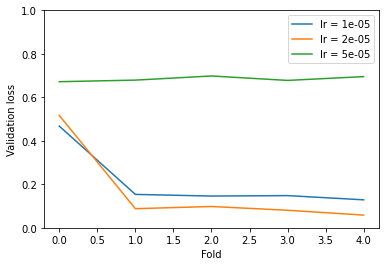

In [56]:
i = 0
for folds_val_loss in lr_val_loss:
  plt.plot(np.arange(5),folds_val_loss, label='lr = '+str(lr_list[i]))
  plt.ylabel('Validation loss')
  plt.xlabel('Fold')
  plt.legend()
  plt.ylim([0, 1])
  i += 1

**Conclusion:**

From the above graph, we conlude that learning rate of 2e-5 gives the least validation loss, therefore the best performance.

## Train with Optimal Hyperparameter

We choose the optimal learning rate 2e-5 we got from previous step, train for 10 epochs with the whole dataset.

In [84]:
# Define some constants
lr = 2e-5

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
EPOCHS = 5
BATCH_SIZE = 32
DROPOUT = 0.3
MAX_LEN = 32
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [85]:
# Cross Validation
kf = KFold(n_splits=5, shuffle=True)


# Create model instance
model = FinetuneBertClassifier(2)
model = model.to(device)

# Define optimizer, loss fucntion and scheduler
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)


fold_history_list = []
fold_count = 1
# For each choice of lr, perform 5-fold cross validation
for train_index, val_index in kf.split(train):
  # Within each fold
  print('Fold: ', fold_count)
  print('-' * 10)
  fold_count += 1

  # Split the training data into train and validation set
  train_data = train.iloc[train_index] 
  val_data = train.iloc[val_index] 

  # Count the number of training and validation set
  num_train_data = len(train_data)
  num_val_data = len(val_data)

  # Create dataloaders for training and validation set
  train_data_loader = create_data_loader(train_data, TOKENIZER, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_data, TOKENIZER, MAX_LEN, BATCH_SIZE)


  # Train the model for some number of epochs
  history = defaultdict(list)

  for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train
    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train_data)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    # Validate
    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val_data)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
  
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

  # When we finish all epochs of current fold, 
  # history will be of size (4, EPOCHS)


  # Then we append all epoch histories in current fold
  # into fold_history_list
  fold_history_list.append(history)



Fold:  1
----------
Epoch 1/5
----------
Train loss 0.49785079034679225 accuracy 0.774384236453202
Val   loss 0.40758809447288513 accuracy 0.8135259356533158
Epoch 2/5
----------
Train loss 0.33902962538974446 accuracy 0.864696223316913
Val   loss 0.4382954682999601 accuracy 0.8141825344714378
Epoch 3/5
----------
Train loss 0.23120109604413167 accuracy 0.912807881773399
Val   loss 0.5261786555250486 accuracy 0.8207485226526592
Epoch 4/5
----------
Train loss 0.15206795508293094 accuracy 0.9446633825944171
Val   loss 0.6875047297216952 accuracy 0.8030203545633617
Epoch 5/5
----------
Train loss 0.10125551634944771 accuracy 0.9637110016420362
Val   loss 0.7195942912561198 accuracy 0.8194353250164149
Fold:  2
----------
Epoch 1/5
----------
Train loss 0.23821454119401697 accuracy 0.9333333333333333
Val   loss 0.06327119421621319 accuracy 0.9737360472751149
Epoch 2/5
----------
Train loss 0.23761937461448443 accuracy 0.9336617405582923
Val   loss 0.06327119421621319 accuracy 0.97373604727

In [95]:
val_acc_list = []
for fold in fold_history_list:
  acc_list = fold['val_acc']
  for acc in acc_list:
    acc = acc.item()
    val_acc_list.append(acc)
    
print(val_acc_list)    

[0.8135259356533158, 0.8141825344714378, 0.8207485226526592, 0.8030203545633617, 0.8194353250164149, 0.9737360472751149, 0.9737360472751149, 0.9737360472751149, 0.9737360472751149, 0.9737360472751149, 0.9684832567301378, 0.9684832567301378, 0.9684832567301378, 0.9684832567301378, 0.9684832567301378, 0.9796320630749015, 0.9796320630749015, 0.9796320630749015, 0.9796320630749015, 0.9796320630749015, 0.9717477003942182, 0.9717477003942182, 0.9717477003942182, 0.9717477003942182, 0.9717477003942182]


Best validation accuracy:  0.9796320630749015


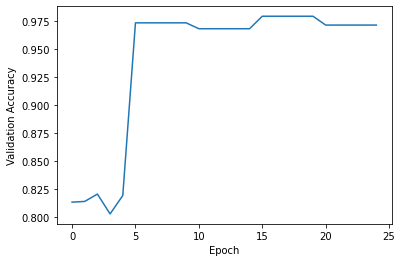

In [100]:
plt.plot(val_acc_list)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')

print('Best validation accuracy: ', max(val_acc_list))

# Testing

In [101]:
BATCH_SIZE = 32
MAX_LEN = 32
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [102]:
# Create test dataloader
test_data_loader = create_data_loader(test, TOKENIZER, MAX_LEN, BATCH_SIZE)

In [105]:
# Make prediction on test set
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test)
)

In [104]:
test_acc.item()

0.5902543671467974